In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
DATADIR = '/content/drive/Shareddrives/AAML_final/Training_Dataset'
CATEGORIES = ['Fire', 'NoFire']

In [ ]:
IMG_SIZE = 64
def create_training_data():
    training_data = []
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=C 1=O

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
              
    return training_data

In [ ]:
training_data = create_training_data()

100%|██████████| 1301/1301 [01:02<00:00, 20.95it/s]


In [ ]:
import random

print(len(training_data))
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

2423
1
1
1
0
1
0
1
0
0
1


In [ ]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0
Y = np.array(Y)
X.shape[1:]

(64, 64, 3)

**Hyperparameter**

In [ ]:
BATCHSIZE_ = 32
EPOCHS_ = 100
VALIDATION_SPLIT_ = 0.3

In [ ]:
# # set up image augmentation
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     horizontal_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1
#     #zoom_range=0.3
#     )
# datagen.fit(X)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D

model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

NameError: ignored

In [ ]:
history = model.fit(X, Y, batch_size=32, epochs=100, validation_split=0.3)
# model.fit_generator(datagen.flow(X, Y, batch_size=32),
#                     epochs=100,
#                     verbose=1)

In [ ]:
model.save('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/train2.h5')

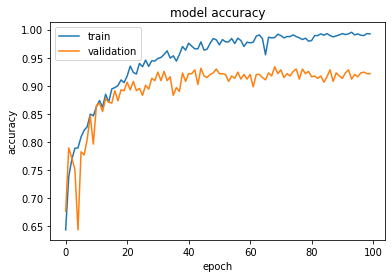

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

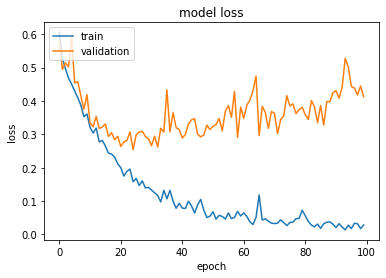

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
model = tf.keras.models.load_model('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/train_nonpruning.h5')

# model.fit_generator(datagen.flow(X, Y, batch_size=32),
#                     epochs=100,
#                   verbose=1)


In [ ]:
 plot_model(model, to_file='model_small.png', show_layer_names=False, show_shapes=True)

Above this line,it's the peocedure of baseline


and it's time to quantize model


**Quantization_model**

In [ ]:
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
import tensorflow as tf
base_model = tf.keras.models.load_model('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/all_prun_0_80.h5')
base_model.summary()

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model #make quantization model

num_images = X.shape[0] * (1 - VALIDATION_SPLIT_)
end_step = np.ceil(num_images / BATCHSIZE_).astype(np.int32) * EPOCHS_

#Define model for quantization
q_aware_model = quantize_model(base_model)

#Recompile part
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_4 (QuantizeL  (None, 64, 64, 3)        3         
 ayer)                                                           
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 62, 62, 16)       483       
 erV2)                                                           
                                                                 
 quant_average_pooling2d (Qu  (None, 31, 31, 16)       3         
 antizeWrapperV2)                                                
                                                                 
 quant_dropout (QuantizeWrap  (None, 31, 31, 16)       1         
 perV2)                                                          
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 29, 29, 32)       4

In [ ]:
import os

q_aware_model.fit(X, Y,
           batch_size=BATCHSIZE_, epochs=EPOCHS_, validation_split=VALIDATION_SPLIT_)

quant_aware_model.fit(X, Y,
           batch_size=BATCHSIZE_, epochs=EPOCHS_, validation_split=VALIDATION_SPLIT_)
#evaluate accuracy
_, baseline_model_accuracy = model.evaluate(
    X, Y, verbose=0)
_, q_aware_model_accuracy = q_aware_model.evaluate(
   X, Y, verbose=0)

In [ ]:
print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Quant_Dense test accuracy:', quant_aware_model_accuracy)

Baseline test accuracy: 0.9768881797790527
Quant test accuracy: 0.9917457699775696
Quant_Dense test accuracy: 0.99092036485672


Baseline test accuracy: 0.9768881797790527
Quant test accuracy: 0.985555112361908
Quant_Conv2D test accuracy: 0.9880313873291016

Baseline test accuracy: 0.9768881797790527
Quant test accuracy: 0.9917457699775696
Quant_Dense test accuracy: 0.99092036485672

**Custom bit part**

In [ ]:
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
import tensorflow as tf

In [ ]:
# Set default quantization configuration
LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer

class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    # Configure how to quantize weights.
    def get_weights_and_quantizers(self, layer):
      return [(layer.kernel, LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
      return [(layer.activation, MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
      # Add this line for each item returned in `get_weights_and_quantizers`
      # , in the same order
      layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
      # Add this line for each item returned in `get_activations_and_quantizers`
      # , in the same order.
      layer.activation = quantize_activations[0]

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
      return []

    def get_config(self):
      return {}

In [ ]:
''' This part is made for modify default quantizeconfig '''
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):
    # Edit bit part
    # Configure weights to quantize with 4-bit instead of 8-bits.
    def get_weights_and_quantizers(self, layer):
      return [(layer.kernel, LastValueQuantizer(num_bits=4, symmetric=True, narrow_range=False, per_axis=False))]
    
    '''# Quantize specific part
    def get_activations_and_quantizers(self, layer):
      # Skip quantizing activations.
      return []

    def set_quantize_activations(self, layer, quantize_activations):
      # Empty since `get_activaations_and_quantizers` returns
      # an empty list.
      return'''

In [ ]:
def apply_quantization_to_specific(layer):
  if isinstance(layer, tf.keras.layers.Dense): #is dense(or other type) layer or not
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

annotated_model = tf.keras.models.clone_model(
    base_model,
    clone_function=apply_quantization_to_specific,
)
# `quantize_apply` requires mentioning `ModifiedDenseQuantizeConfig` with `quantize_scope`:
with quantize_scope(
  {'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
  # Use `quantize_apply` to actually make the model quantization aware.
  quant_modified_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_modified_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 16)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 31, 31, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 32)       0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

**Modified part result**

In [ ]:
quant_modified_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

quant_modified_aware_model.fit(X, Y,
           batch_size=BATCHSIZE_, epochs=EPOCHS_, validation_split=VALIDATION_SPLIT_)
_, quant_modified_aware_model_accuracy = quant_modified_aware_model.evaluate(
   X, Y, verbose=0)
print('Quant_bit test accuracy:', quant_modified_aware_model_accuracy)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


53/53 [==============================] - 9s 147ms/step - loss: 0.1036 - accuracy: 0.9752 - val_loss: 0.0322 - val_accuracy: 0.9904
Epoch 2/100
53/53 [==============================] - 7s 139ms/step - loss: 0.0760 - accuracy: 0.9823 - val_loss: 0.0424 - val_accuracy: 0.9890
Epoch 3/100
53/53 [==============================] - 7s 136ms/step - loss: 0.0618 - accuracy: 0.9788 - val_loss: 0.0452 - val_accuracy: 0.9835
Epoch 4/100
53/53 [==============================] - 7s 137ms/step - loss: 0.0637 - accuracy: 0.9794 - val_loss: 0.0476 - val_accuracy: 0.9876
Epoch 5/100
53/53 [==============================] - 7s 135ms/step - loss: 0.0516 - accuracy: 0.9853 - val_loss: 0.0436 - val_accuracy: 0.9904
Epoch 6/100
53/53 [==============================] - 7s 136ms/step - loss: 0.0520 - accuracy: 0.9811 - val_loss: 0.0525 - val_accuracy: 0.9821
Epoch 7/100
53/53 [==============================] - 7s 134ms/step - loss: 0.0518 - accuracy: 0.9841 - val_loss: 0.0326 - val_accuracy: 0.9904
Epoch 8/100

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9qsx8c8r/assets


INFO:tensorflow:Assets written to: /tmp/tmp9qsx8c8r/assets


In [ ]:
#converter = tf.lite.TFLiteConverter.from_keras_model(quantized_tflite_model)
#quanted_tflite_model = converter.convert()

_, quanted_tflite_file = tempfile.mkstemp('.tflite')

with open(quanted_tflite_file, 'wb') as f:
  f.write(quantized_tflite_model)

print('Saved quanted TFLite model to:', quanted_tflite_file)

Saved quanted TFLite model to: /tmp/tmpe08owr6w.tflite
